In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import statsmodels.api as sm
import numpy as np
from fredapi import Fred
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
fred = Fred(api_key='926acb260a284a87c73acdef0d2c2bd7')

## <span style = 'color:blue'> 1. Setting up Price data and market data

In [2]:
start_date = datetime(2016, 1, 1) 
end_date = datetime.now()
full_date_range = pd.date_range(start = start_date, end = end_date)

# Derive wmt price data
wmt = yf.download('WMT', start = start_date, end = end_date)
wmt.columns = wmt.columns.get_level_values(0)
wmt = wmt.reindex(full_date_range)

# Derive the US market data
market = yf.download('^GSPC', start = start_date, end = end_date)
market.columns = market.columns.get_level_values(0)
market = market.reindex(full_date_range)

print("wmt's data")
display(wmt)

print("market's data")
display(market)

C:\Users\Acer\AppData\Local\Temp\ipykernel_16644\2678496962.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  wmt = yf.download('WMT', start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\Acer\AppData\Local\Temp\ipykernel_16644\2678496962.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market = yf.download('^GSPC', start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed

wmt's data


Price,Close,High,Low,Open,Volume
2016-01-01,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,NaN
2016-01-04,17.109713,17.118064,16.803486,16.842461,35967600.0
2016-01-05,17.516163,17.552353,17.218288,17.268397,39978000.0
...,...,...,...,...,...
2025-11-14,102.480003,102.489998,98.879997,100.199997,23419600.0
2025-11-15,NaN,NaN,NaN,NaN,NaN
2025-11-16,NaN,NaN,NaN,NaN,NaN
2025-11-17,102.949997,103.315002,102.100098,102.580002,15281239.0


market's data


Price,Close,High,Low,Open,Volume
2016-01-01,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,NaN
2016-01-04,2012.660034,2038.199951,1989.680054,2038.199951,4.304880e+09
2016-01-05,2016.709961,2021.939941,2004.170044,2013.780029,3.706620e+09
...,...,...,...,...,...
2025-11-14,6734.109863,6774.310059,6646.870117,6672.140137,5.042660e+09
2025-11-15,NaN,NaN,NaN,NaN,NaN
2025-11-16,NaN,NaN,NaN,NaN,NaN
2025-11-17,6672.410156,6754.500000,6638.899902,6713.609863,3.196879e+09


## <span style = 'color:blue'> 2. Setting up Macroeconomic Data

In [3]:
types = ['Unemployment', 'GDP', 'Interest', 'Housing', 'CPI', 'PPI', ]
series_id = ['UNRATE', 'GDP','DFF', 'CSUSHPINSA', 'CPIAUCSL', 'PPIACO']

for (type, id) in zip(types, series_id):
    globals()[f'{type}'] = fred.get_series(id).to_frame()
    globals()[f'{type}'].rename(columns = {0: type}, inplace = True)
    print(globals()[f'{type}'].head(2))

            Unemployment
1948-01-01           3.4
1948-02-01           3.8
            GDP
1946-01-01  NaN
1946-04-01  NaN
            Interest
1954-07-01      1.13
1954-07-02      1.25
            Housing
1975-01-01      NaN
1975-02-01      NaN
              CPI
1947-01-01  21.48
1947-02-01  21.62
             PPI
1913-01-01  12.1
1913-02-01  12.0


### <span style = 'color:red'> Calculate the inflation rate and Reallign the dates

In [4]:
adj_start_date = datetime(2016, 4, 1)
CPI_inflation = CPI.pct_change(12) # Year-over-year change
print(CPI_inflation.dropna().head(2))
CPI_inflation = CPI_inflation.loc[start_date:]

PPI_inflation = PPI.pct_change(12) # Year-over-year change
print(PPI_inflation.dropna().head(2))
PPI_inflation = PPI_inflation.loc[start_date:]

GDP_growth = GDP.pct_change(1) # Calculate quarterly growth rates
GDP_growth = (1 + GDP_growth)**(4)-1 # Annualize the growth rates 
print(GDP_growth.dropna().head(2))
GDP_growth =GDP_growth.loc[start_date:]

Interest = Interest.loc[adj_start_date:]
Unrate = Unemployment.loc[adj_start_date:]

                 CPI
1948-01-01  0.102421
1948-02-01  0.094820
                 PPI
1914-01-01 -0.024793
1914-02-01 -0.016667
                 GDP
1947-04-01  0.046929
1947-07-01  0.060131


## <span style = 'color:blue'> 3. Setting up Financial Data

Text(0, 0.5, 'Close price ($)')

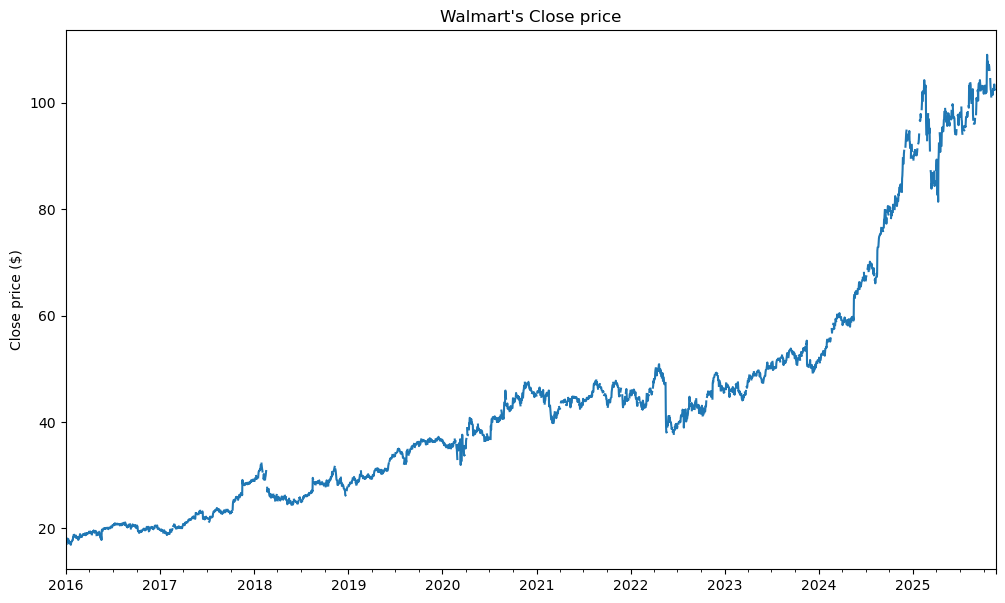

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (12, 7))
wmt.Close.plot(ax = ax)
ax.set_title("Walmart's Close price")
ax.set_xlabel('')
ax.set_ylabel('Close price ($)')

In [6]:
# ratios = pd.read_excel('Ratios.xlsx')
# ratios = ratios.T
# ratios.columns = ratios.iloc[0]
# ratios = ratios.iloc[1:]
# ratios.index = pd.to_datetime(ratios.index)
# ratios.loc[ratios['Incremental Operating Margin'] == '—', 'Incremental Operating Margin'] = np.nan
# ratios = ratios.dropna()
# ratios.to_csv('ratios_cleaned.csv')

In [7]:
ratios = pd.read_csv('ratios_cleaned.csv', index_col = 0)
ratios = ratios.dropna()
ratios.index = pd.to_datetime(ratios.index)
ratios

,Return on Common Equity,Return on Assets,Return on Capital,Return on Invested Capital,Gross Margin,EBITDA Margin,Operating Margin,Incremental Operating Margin,Pretax Margin,Income before XO Margin,Net Income Margin,Net Income to Common Margin,Effective Tax Rate,Dvd Payout Ratio,Sustainable Growth Rate
2015-10-31,19.01,7.31,12.76,12.90,25.52,6.88,4.87,-34.59,4.40,2.91,2.81,2.81,33.86,47.55,9.97
2016-01-31,18.15,7.29,12.61,12.49,25.19,7.00,5.12,-68.86,4.70,3.66,3.53,3.53,22.09,34.13,11.95
2016-07-31,18.96,7.43,13.32,13.38,25.96,7.18,5.10,15.36,4.63,3.22,3.12,3.12,30.54,41.35,11.12
2018-10-31,6.96,2.37,5.31,0.56,25.44,6.09,3.99,12.94,2.06,1.45,1.37,1.37,29.46,87.72,0.86
2019-01-31,8.87,3.15,6.55,0.95,24.41,6.34,4.37,63.34,4.08,2.75,2.66,2.66,32.68,40.82,5.25
2020-04-30,22.03,6.43,11.50,10.56,24.21,5.95,3.88,2.61,4.01,3.03,2.96,2.96,24.50,38.32,13.59
2020-07-31,24.57,7.58,13.24,10.72,25.45,6.41,4.40,6.46,6.28,4.67,4.70,4.70,25.53,23.61,18.77
2020-10-31,25.79,8.05,14.09,10.88,25.51,6.35,4.29,15.78,5.28,3.86,3.81,3.81,26.90,29.79,18.11
2021-04-30,16.72,5.22,9.24,10.59,25.33,6.92,5.00,45.69,2.78,2.03,1.97,1.97,26.87,56.74,7.23
2021-07-31,12.90,4.22,7.71,11.18,25.43,7.09,5.21,39.17,4.20,3.09,3.03,3.03,26.32,36.06,8.25


In [8]:
# Get the EPS
income = pd.read_excel("Income Statement.xlsx", index_col=0)
eps = income.loc['Diluted EPS, GAAP', :]
eps = eps.to_frame()
eps.columns = ['Diluted EPS']

# Derive the Current Ratio, Cash Conversion Cycle
balance = pd.read_excel("Balance Sheet.xlsx", index_col=0)
current = balance.loc['Current Ratio', :].iloc[0,:]
ccc = balance.loc['Cash Conversion Cycle', :].iloc[0,:]
dte = balance.loc['Debt to Equity', :]

## <span style = 'color:blue'>4. Merge the data

In [9]:
# Readjust the start date so that the price data only includes non-null values
adj_start_date = datetime(2016, 4, 1)
df = pd.DataFrame({'Walmart': wmt['Close'],
                   'S&P500': market['Close'],
                   'Volume': wmt['Volume']})
merge_data = [GDP_growth, CPI_inflation, PPI_inflation, Interest, ratios, eps, current, ccc, dte, Unrate]
for data in merge_data:
    df = df.merge(data, how = 'left', left_index = True, right_index = True)

df = df.ffill()
df = df.loc[adj_start_date:]
display(df)

C:\Users\Acer\AppData\Local\Temp\ipykernel_16644\2081060853.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill()


,Walmart,S&P500,Volume,GDP,CPI,PPI,Interest,Return on Common Equity,Return on Assets,Return on Capital,...,Net Income Margin,Net Income to Common Margin,Effective Tax Rate,Dvd Payout Ratio,Sustainable Growth Rate,Diluted EPS,Current Ratio,Cash Conversion Cycle,Debt to Equity,Unemployment
2016-04-01,19.367788,2072.780029,19807200.0,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,...,3.53,3.53,22.09,34.13,11.95,NaN,0.93,11.05,0.554831,5.1
2016-04-02,19.367788,2072.780029,19807200.0,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,...,3.53,3.53,22.09,34.13,11.95,NaN,0.93,11.05,0.554831,5.1
2016-04-03,19.367788,2072.780029,19807200.0,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,...,3.53,3.53,22.09,34.13,11.95,NaN,0.93,11.05,0.554831,5.1
2016-04-04,19.379007,2066.129883,20470200.0,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,...,3.53,3.53,22.09,34.13,11.95,NaN,0.93,11.05,0.554831,5.1
2016-04-05,19.249994,2045.170044,17337000.0,0.040717,0.011726,-0.040335,0.37,18.15,7.29,12.61,...,3.53,3.53,22.09,34.13,11.95,NaN,0.93,11.05,0.554831,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-14,102.480003,6734.109863,23419600.0,0.060387,0.030227,0.027323,3.88,22.80,7.29,13.63,...,2.71,2.71,22.61,167.83,-15.46,0.88,0.79,4.00,0.671237,4.3
2025-11-15,102.480003,6734.109863,23419600.0,0.060387,0.030227,0.027323,3.88,22.80,7.29,13.63,...,2.71,2.71,22.61,167.83,-15.46,0.88,0.79,4.00,0.671237,4.3
2025-11-16,102.480003,6734.109863,23419600.0,0.060387,0.030227,0.027323,3.88,22.80,7.29,13.63,...,2.71,2.71,22.61,167.83,-15.46,0.88,0.79,4.00,0.671237,4.3
2025-11-17,102.949997,6672.410156,15281239.0,0.060387,0.030227,0.027323,3.88,22.80,7.29,13.63,...,2.71,2.71,22.61,167.83,-15.46,0.88,0.79,4.00,0.671237,4.3


## <span style = 'color:blue'>5. Manually Filter out uneeded Variables

# Fundamental Analysis Ratios



| Category | Ratio Selected | Formula | Purpose |
|----------|----------------|---------|----------|
| **Solvency Ratio** | Debt to Equity | $$\text{Debt to Equity} = \frac{\text{Total Debt}}{\text{Shareholders' Equity}}$$ | Measures long-term financial leverage and risk|
| **Activity Ratio** | Cash Conversion Cycle (CCC) | $$\text{CCC} = \text{DIO} + \text{DSO} - \text{DPO}$$ | Measures time to convert inventory investment back into cash |
| **Liquidity Ratio** | Current Ratio | $$\text{Current Ratio} = \frac{\text{Current Assets}}{\text{Current Liabilities}}$$ | Measures short-term solvency (ability to meet short-term obligations) |
| **Profitability Ratio** | Net Income Margin | $$\text{Net Margin} = \frac{\text{Net Income}}{\text{Revenue}} \times 100\%$$ | Shows overall profitability after all expenses |


In [10]:
# Columns to keep
relevant_columns = ["GDP","CPI","Interest","Net Income Margin","Diluted EPS","Walmart","S&P500", 'Current Ratio', 'Cash Conversion Cycle', 'Debt to Equity', 'Volume', 'Unemployment']
df = df[relevant_columns]
df

,GDP,CPI,Interest,Net Income Margin,Diluted EPS,Walmart,S&P500,Current Ratio,Cash Conversion Cycle,Debt to Equity,Volume,Unemployment
2016-04-01,0.040717,0.011726,0.37,3.53,NaN,19.367788,2072.780029,0.93,11.05,0.554831,19807200.0,5.1
2016-04-02,0.040717,0.011726,0.37,3.53,NaN,19.367788,2072.780029,0.93,11.05,0.554831,19807200.0,5.1
2016-04-03,0.040717,0.011726,0.37,3.53,NaN,19.367788,2072.780029,0.93,11.05,0.554831,19807200.0,5.1
2016-04-04,0.040717,0.011726,0.37,3.53,NaN,19.379007,2066.129883,0.93,11.05,0.554831,20470200.0,5.1
2016-04-05,0.040717,0.011726,0.37,3.53,NaN,19.249994,2045.170044,0.93,11.05,0.554831,17337000.0,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-14,0.060387,0.030227,3.88,2.71,0.88,102.480003,6734.109863,0.79,4.00,0.671237,23419600.0,4.3
2025-11-15,0.060387,0.030227,3.88,2.71,0.88,102.480003,6734.109863,0.79,4.00,0.671237,23419600.0,4.3
2025-11-16,0.060387,0.030227,3.88,2.71,0.88,102.480003,6734.109863,0.79,4.00,0.671237,23419600.0,4.3
2025-11-17,0.060387,0.030227,3.88,2.71,0.88,102.949997,6672.410156,0.79,4.00,0.671237,15281239.0,4.3


## <span style = 'color:blue'>6. Calculate the technical indicators

In [11]:
import talib

df['MA30'] = talib.MA(df['Walmart'], 30)
df['MA7'] = talib.MA(df['Walmart'], 7)
# Trend Indicators (complementary to MA)
df['RSI'] = talib.RSI(df['Walmart'], timeperiod=14)  # Momentum oscillator
df['ADX'] = talib.ADX(df['Walmart'], df['Walmart'], df['Walmart'], timeperiod=14)  # Trend strength

# Volatility Indicator
df['ATR'] = talib.ATR(df['Walmart'], df['Walmart'], df['Walmart'], timeperiod=14)  # Average True Range

# Volume-based Indicator (if you have volume data)
df['OBV'] = talib.OBV(df['Walmart'], df['Volume'])  # On Balance Volume

lagged_df = df.drop(['Walmart', 'S&P500'], axis = 1).shift(1)
lagged_df['Walmart'] = df['Walmart']
lagged_df['S&P500'] = df['S&P500']
lagged_df.to_csv("final_data.csv")
display(lagged_df)

,GDP,CPI,Interest,Net Income Margin,Diluted EPS,Current Ratio,Cash Conversion Cycle,Debt to Equity,Volume,Unemployment,MA30,MA7,RSI,ADX,ATR,OBV,Walmart,S&P500
2016-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.367788,2072.780029
2016-04-02,0.040717,0.011726,0.37,3.53,NaN,0.93,11.05,0.554831,19807200.0,5.1,NaN,NaN,NaN,NaN,NaN,1.980720e+07,19.367788,2072.780029
2016-04-03,0.040717,0.011726,0.37,3.53,NaN,0.93,11.05,0.554831,19807200.0,5.1,NaN,NaN,NaN,NaN,NaN,1.980720e+07,19.367788,2072.780029
2016-04-04,0.040717,0.011726,0.37,3.53,NaN,0.93,11.05,0.554831,19807200.0,5.1,NaN,NaN,NaN,NaN,NaN,1.980720e+07,19.379007,2066.129883
2016-04-05,0.040717,0.011726,0.37,3.53,NaN,0.93,11.05,0.554831,20470200.0,5.1,NaN,NaN,NaN,NaN,NaN,4.027740e+07,19.249994,2045.170044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-14,0.060387,0.030227,3.88,2.71,0.88,0.79,4.00,0.671237,18088500.0,4.3,104.232000,102.801428,45.820484,16.104272,0.543937,2.342825e+09,102.480003,6734.109863
2025-11-15,0.060387,0.030227,3.88,2.71,0.88,0.79,4.00,0.671237,23419600.0,4.3,104.013667,102.785714,45.434977,15.606113,0.509370,2.319406e+09,102.480003,6734.109863
2025-11-16,0.060387,0.030227,3.88,2.71,0.88,0.79,4.00,0.671237,23419600.0,4.3,103.880667,102.770001,45.434977,15.143536,0.472986,2.319406e+09,102.480003,6734.109863
2025-11-17,0.060387,0.030227,3.88,2.71,0.88,0.79,4.00,0.671237,23419600.0,4.3,103.705667,102.754288,45.434977,14.714001,0.439201,2.319406e+09,102.949997,6672.410156


## Data Preparation and Processing

The initial phase of this study involved the **comprehensive preparation and processing of a multifaceted dataset** to ensure its suitability for time series analysis and predictive modeling. This rigorous procedure encompassed data collection, cleaning, feature engineering, and a time-series-appropriate splitting strategy.


The primary dataset was meticulously constructed through the integration of three distinct data sources, aligning disparate data frequencies into a single comprehensive daily time series. The first component, **Stock Price Data**, comprised the daily closing prices and trading volumes for **Walmart (WMT)** and the **S&P 500 index (^GSPC)**. This high-frequency data was efficiently retrieved using the `yfinance` API, covering the period from January 1, 2016, to the present.The second component consisted of **Key Macroeconomic Indicators** obtained from the Federal Reserve Economic Data (FRED) API. These indicators included the **Gross Domestic Product (`GDP`)** and the **Consumer Price Index (`CPIAUCSL`)**, providing necessary context on the broader economic environment.Finally, the third component involved **Company Financial Metrics**. Instead of relying on external files, these fundamental analysis ratios were **calculated directly** from Walmart's reported financial statements. The specific ratios included **Net Income Margin**, **Diluted EPS**, **Current Ratio**, **Cash Conversion Cycle**, and **Debt to Equity**, providing insight into the company's profitability, liquidity, solvency, and operational efficiency. All collected series were aligned to a common daily date range and merged into a single DataFrame, with forward-filling used to address the lower frequency of the macroeconomic and financial statement data.


The following table details the fundamental analysis ratios calculated and integrated into the dataset, along with their formulas and purpose:

| Category | Ratio Selected | Formula | Purpose |
|:----------|:----------------|:---------|:----------|
| **Solvency Ratio** | Debt to Equity | $$\text{Debt to Equity} = \frac{\text{Total Debt}}{\text{Shareholders' Equity}}$$ | Measures long-term financial leverage and risk|
| **Activity Ratio** | Cash Conversion Cycle (CCC) | $$\text{CCC} = \text{DIO} + \text{DSO} - \text{DPO}$$ | Measures the time (in days) required to convert investment in inventory and resources back into cash |
| **Liquidity Ratio** | Current Ratio | $$\text{Current Ratio} = \frac{\text{Current Assets}}{\text{Current Liabilities}}$$ | Measures short-term solvency, indicating the ability to meet short-term obligations |
| **Profitability Ratio** | Net Income Margin | $$\text{Net Margin} = \frac{\text{Net Income}}{\text{Revenue}} \times 100\%$$ | Shows overall profitability after all expenses as a percentage of revenue |

---

### Data Cleaning and Alignment

The merged dataset underwent a systematic cleaning process. The principal challenge, arising from the varying update frequencies of the source data, was addressed by using a **forward-fill (`ffill`) strategy** to handle missing values, which propagates the last observed value for lower-frequency macroeconomic and financial statement data—an appropriate technique in a time-series context. Post-merger, the dataset was **trimmed to commence from April 1, 2016**, to guarantee complete and valid data coverage across all features from this starting point. Data integrity was further ensured by standardizing the date index and explicitly converting all feature columns to appropriate **numeric data types**. The process concluded with a manual filtering step to retain only the variables deemed relevant for the subsequent modeling phase.

---

### Feature Engineering and Transformation

To enhance the predictive power of the model, several new features were engineered. **Macroeconomic transformations** included calculating the year-over-year inflation rates for CPI and PPI using a 12-period percentage change, as well as annualizing the quarterly GDP growth rate. Furthermore, using the `TA-Lib` library, a set of **technical indicators** was computed on the Walmart price series, including Moving Averages (`MA30`, `MA7`), Relative Strength Index (`RSI`), Average Directional Index (`ADX`), Average True Range (`ATR`), and On-Balance Volume (`OBV`). Crucially, to mitigate **look-ahead bias** in time series modeling, all feature variables, excluding the target variables (`Walmart`, `S&P500`), were **lagged by one day**. The final dataset, including: `GDP`, `CPI`, `Interest`, `Net Income Margin`, `Diluted EPS`, `Walmart`, `S&P500`, `Current Ratio`, `Cash Conversion Cycle`, `Debt to Equity`, `Volume`, `MA30`, `MA7`, `RSI`, `ADX`, `ATR`, and `OBV`, was subsequently exported as `final_data.csv`.

---

### Data Splitting Strategy

The final step in data preparation was the **chronological splitting** of the dataset, a critical requirement for valid time series modeling that preserves the temporal order. For use with models like LSTM, the data was partitioned such that all observations **before January 1, 2025, were designated for training**, while the data **from January 1, 2025, onward was strictly reserved for validation and testing**. This approach ensures a robust and realistic evaluation of the models' out-of-sample predictive performance.

## <span style = 'color:blue'>6. Filter out the values 

In [12]:
# # ...existing code...
# import numpy as np
# from fredapi import Fred
# from sklearn.model_selection import train_test_split, cross_val_score, cross_val_score, StratifiedKFold, cross_validate
# from sklearn.ensemble import StackingClassifier, RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.svm import SVR
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import FastICA # Changed from PCA to FastICA
# fred = Fred(api_key='926acb260a284a87c73acdef0d2c2bd7')
# # ...existing code...

# # New Cell for ICA Feature Analysis
# print("--- ICA for Feature Analysis ---") # Updated title

# # Load the preprocessed data
# df_ica = pd.read_csv('final_data.csv', index_col=0, parse_dates=True) # Renamed df_pca to df_ica

# # Drop rows with any NaN values that might still be present
# df_ica = df_ica.dropna()

# # Define features for ICA
# # Exclude 'Walmart' (target) and 'S&P500' (often treated as a separate market factor or target)
# # All other columns are considered features for dimensionality reduction.
# features_for_ica = df_ica.drop(columns=['Walmart', 'S&P500'], errors='ignore')

# # Ensure there are features left to perform ICA on
# if features_for_ica.empty:
#     print("No features remaining after excluding 'Walmart' and 'S&P500'. Cannot perform ICA.")
# else:
#     # Scale the features before applying ICA
#     scaler_ica = StandardScaler()
#     scaled_features = scaler_ica.fit_transform(features_for_ica)

#     # Perform ICA
#     # We'll initially keep all components. random_state for reproducibility.
#     ica = FastICA(n_components=5, random_state=42, max_iter=1000, tol=0.05) # Instantiated FastICA
#     ica.fit(scaled_features)

#     # ICA does not have 'explained_variance_ratio' like PCA.
#     # We will skip plotting explained variance as it's not applicable to ICA.

#     print(f"\nOriginal number of features: {features_for_ica.shape[1]}")
    
#     # You can inspect the components themselves to see feature contributions
#     # This shows how much each original feature contributes to each independent component.
#     num_components_to_show = min(5, ica.components_.shape[0]) # Corrected: Use ica.components_.shape[0]
#     print(f"\nFeature contributions for the first {num_components_to_show} Independent Components:") # Updated text
#     ica_components_df = pd.DataFrame(ica.components_[:num_components_to_show],
#                                      columns=features_for_ica.columns,
#                                      index=[f'IC{i+1}' for i in range(num_components_to_show)]) # Updated index
#     display(ica_components_df)

#     # --- Plotting ICA Feature Contributions ---
#     if ica.components_.shape[0] >= 2: # Corrected: Use ica.components_.shape[0]
#         plt.figure(figsize=(12, 10))
#         # Get the contributions for the first two independent components
#         components = ica.components_[:2].T # Transpose to get features as rows, ICs as columns
        
#         # Define colors for IC1-dominant, IC2-dominant, and mixed/equally aligned features
#         color_ic1_dominant = 'blue' # Updated variable name
#         color_ic2_dominant = 'green' # Updated variable name
#         color_mixed = 'gray' # For features with similar contributions on both
# # ...existing code...

#         feature_colors = []
        
#         # Assign colors based on which IC the feature primarily contributes to (absolute value)
#         for i, feature in enumerate(features_for_ica.columns):
#             contribution_ic1 = components[i, 0] # Updated variable name
#             contribution_ic2 = components[i, 1] # Updated variable name
            
#             if abs(contribution_ic1) > abs(contribution_ic2):
#                 feature_colors.append(color_ic1_dominant)
#             elif abs(contribution_ic2) > abs(contribution_ic1):
#                 feature_colors.append(color_ic2_dominant)
#             else: # If contributions are equal or very close
#                 feature_colors.append(color_mixed)

#         # Plot the arrows and text labels
#         for i, feature in enumerate(features_for_ica.columns):
#             plt.arrow(0, 0, components[i, 0], components[i, 1], # Used 'components'
#                       head_width=0.03, head_length=0.03, # Reduced arrow size
#                       fc=feature_colors[i], ec=feature_colors[i])
#             plt.text(components[i, 0] * 1.15, components[i, 1] * 1.15, # Used 'components'
#                      feature, color=feature_colors[i], ha='center', va='center')

#         # Create a custom legend for the color groups
#         from matplotlib.lines import Line2D
#         legend_elements = [Line2D([0], [0], color=color_ic1_dominant, lw=4, label='Primarily IC1-aligned'), # Updated label
#                            Line2D([0], [0], color=color_ic2_dominant, lw=4, label='Primarily IC2-aligned'), # Updated label
#                            Line2D([0], [0], color=color_mixed, lw=4, label='Mixed/Equally aligned')]
        
#         plt.xlabel(f'Independent Component 1') # Updated label, removed explained variance
#         plt.ylabel(f'Independent Component 2') # Updated label, removed explained variance
#         plt.title('ICA Feature Contributions (First Two Independent Components) - Grouped by Dominant IC') # Updated title
#         plt.grid(True)
#         plt.axhline(0, color='grey', linewidth=0.8)
#         plt.axvline(0, color='grey', linewidth=0.8)
#         plt.xlim(min(components[:, 0])*1.2, max(components[:, 0])*1.2) # Used 'components'
#         plt.ylim(min(components[:, 1])*1.2, max(components[:, 1])*1.2) # Used 'components'
#         plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#         plt.tight_layout()
#         plt.show()
#     else:
#         print("\nNot enough independent components (less than 2) to plot feature contributions in 2D.") # Updated text

# print("\n--- ICA Analysis Complete ---")

In [13]:
# # ...existing code...
# df = pd.read_csv('final_data.csv', index_col = 0, parse_dates=True)
# # ...existing code...

# # New Cell for PCA Feature Analysis
# print("--- PCA for Feature Analysis ---")

# # Load the preprocessed data
# df_pca = pd.read_csv('final_data.csv', index_col=0, parse_dates=True)

# # Drop rows with any NaN values that might still be present
# df_pca = df_pca.dropna()

# # Define features for PCA
# # Exclude 'Walmart' (target) and 'S&P500' (often treated as a separate market factor or target)
# # All other columns are considered features for dimensionality reduction.
# features_for_pca = df_pca.drop(columns=['Walmart', 'S&P500'], errors='ignore')

# # Ensure there are features left to perform PCA on
# if features_for_pca.empty:
#     print("No features remaining after excluding 'Walmart' and 'S&P500'. Cannot perform PCA.")
# else:
#     # Scale the features before applying PCA
#     scaler_pca = StandardScaler()
#     scaled_features = scaler_pca.fit_transform(features_for_pca)

#     # Perform PCA
#     # We'll initially keep all components to analyze explained variance
#     pca = PCA()
#     pca.fit(scaled_features)

#     # Explained variance ratio
#     explained_variance_ratio = pca.explained_variance_ratio_
#     cumulative_explained_variance = np.cumsum(explained_variance_ratio)

#     print(f"\nOriginal number of features: {features_for_pca.shape[1]}")
#     print("\nExplained Variance Ratio by each Principal Component:")
#     for i, ratio in enumerate(explained_variance_ratio):
#         print(f"  PC{i+1}: {ratio:.4f} (Cumulative: {cumulative_explained_variance[i]:.4f})")

#     # Plot explained variance
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
#     plt.title('Cumulative Explained Variance by Principal Components')
#     plt.xlabel('Number of Principal Components')
#     plt.ylabel('Cumulative Explained Variance')
#     plt.grid(True)
#     plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
#     plt.axhline(y=0.90, color='g', linestyle='-', label='90% Explained Variance')
#     plt.legend()
#     plt.show()

#     # Determine how many components explain a certain percentage of variance
#     n_components_90 = np.where(cumulative_explained_variance >= 0.90)[0][0] + 1
#     n_components_95 = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

#     print(f"\nNumber of components explaining 90% of variance: {n_components_90}")
#     print(f"Number of components explaining 95% of variance: {n_components_95}")

#     # You can also inspect the components themselves to see feature loadings
#     # This shows how much each original feature contributes to each principal component.
#     # For example, to see the loadings for the first few components:
#     num_components_to_show = min(5, pca.n_components_) # Show up to the first 5 components
#     print(f"\nFeature loadings for the first {num_components_to_show} Principal Components:")
#     pca_components_df = pd.DataFrame(pca.components_[:num_components_to_show],
#                                      columns=features_for_pca.columns,
#                                      index=[f'PC{i+1}' for i in range(num_components_to_show)])
#     display(pca_components_df)

# # ...existing code...
#     # --- Plotting PCA Loading Vectors ---
#     if pca.n_components_ >= 2: # Ensure at least 2 components exist for a 2D plot
#         plt.figure(figsize=(12, 10))
#         # Get the loadings for the first two principal components
#         loadings = pca.components_[:2].T # Transpose to get features as rows, PCs as columns
        
#         # Define colors for PC1-dominant, PC2-dominant, and mixed/equally aligned features
#         color_pc1_dominant = 'blue'
#         color_pc2_dominant = 'green'
#         color_mixed = 'gray' # For features with similar loadings on both

#         feature_colors = []
        
#         # Assign colors based on which PC the feature primarily loads on (absolute value)
#         for i, feature in enumerate(features_for_pca.columns):
#             loading_pc1 = loadings[i, 0]
#             loading_pc2 = loadings[i, 1]
            
#             if abs(loading_pc1) > abs(loading_pc2):
#                 feature_colors.append(color_pc1_dominant)
#             elif abs(loading_pc2) > abs(loading_pc1):
#                 feature_colors.append(color_pc2_dominant)
#             else: # If loadings are equal or very close
#                 feature_colors.append(color_mixed)

# # ...existing code...
#         # Plot the arrows and text labels
#         for i, feature in enumerate(features_for_pca.columns):
#             plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
#                       head_width=0.03, head_length=0.03, # Reduced arrow size
#                       fc=feature_colors[i], ec=feature_colors[i])
#             plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, 
#                      feature, color=feature_colors[i], ha='center', va='center')

#         # Create a custom legend for the color groups
#         from matplotlib.lines import Line2D
#         legend_elements = [Line2D([0], [0], color=color_pc1_dominant, lw=4, label='Primarily PC1-aligned'),
#                            Line2D([0], [0], color=color_pc2_dominant, lw=4, label='Primarily PC2-aligned'),
#                            Line2D([0], [0], color=color_mixed, lw=4, label='Mixed/Equally aligned')]
        
#         plt.xlabel(f'Principal Component 1 (Explains {explained_variance_ratio[0]*100:.2f}%)')
#         plt.ylabel(f'Principal Component 2 (Explains {explained_variance_ratio[1]*100:.2f}%)')
#         plt.title('PCA Feature Loadings (First Two Principal Components) - Grouped by Dominant PC')
#         plt.grid(True)
#         plt.axhline(0, color='grey', linewidth=0.8)
#         plt.axvline(0, color='grey', linewidth=0.8)
#         plt.xlim(min(loadings[:, 0])*1.2, max(loadings[:, 0])*1.2)
#         plt.ylim(min(loadings[:, 1])*1.2, max(loadings[:, 1])*1.2)
#         plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#         plt.tight_layout()
#         plt.show()
#     else:
#         print("\nNot enough principal components (less than 2) to plot loading vectors in 2D.")

# print("\n--- PCA Analysis Complete ---")

## <span style = 'color:blue'> LSTM Model

In [14]:
# # ...existing code...
# import numpy as np
# import tensorflow as tf
# from sklearn.preprocessing import StandardScaler # Changed from MinMaxScaler to StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization # Import BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Import callbacks
# import matplotlib.pyplot as plt
# import pickle # Import pickle for saving scalers
# import pandas as pd # Ensure pandas is imported for date handling

# df = pd.read_csv('final_data.csv', index_col = 0, parse_dates=True)
# df = df.loc['2017 ':]
# df = df[['Walmart', 'S&P500', 'Diluted EPS', 'MA30', 'MA7']]
# # Let's explicitly add the desired lags for the LSTM model here.
# # Create 5 lagged Walmart features (the target itself) from the current 'Walmart' column in df
# for i in range(1, 1): # FIXED: Lags 1 to 5
#     df[f'Walmart_Lag{i}'] = df['Walmart'].shift(i)

# # Create 5 lagged S&P500 features from the current 'S&P500' column in df
# for i in range(1, 1): # FIXED: Lags 1 to 5
#     df[f'S&P500_Lag{i}'] = df['S&P500'].shift(i)

# # Prepare the data for LSTM
# # Drop rows with NaN values, which might be introduced by new lagged features
# df_lstm = df.dropna().copy()

# # Define features (X) and target (y)
# # The target is the 'Walmart' close price
# # Features are all other columns, EXCLUDING current-day 'Walmart' (target) and 'S&P500'.
# # Other columns like 'MA30', 'MA7', 'ATR', and macro/ratios are already lagged by 1 day in df_lstm,
# # so they are valid features and should NOT be excluded.
# features_to_exclude_from_X_lstm = ['Walmart', 'S&P500']
# X_data = df_lstm.drop(columns=features_to_exclude_from_X_lstm).values
# y_data = df_lstm['Walmart'].values.reshape(-1, 1) # Reshape for scaler


# # Scale the features and target
# scaler_X = StandardScaler()
# X_scaled = scaler_X.fit_transform(X_data)

# scaler_y = StandardScaler()
# y_scaled = scaler_y.fit_transform(y_data)

# # Define the number of time steps (look-back window)
# n_steps = 7

# # Create sequences for LSTM
# def create_sequences(X, y, n_steps):
#     X_seq, y_seq = [], []
#     for i in range(len(X) - n_steps):
#         X_seq.append(X[i:(i + n_steps), :])
#         y_seq.append(y[i + n_steps, 0]) # Predict the next day's price (y_t using X_{t-n_steps} to X_{t-1})
#     return np.array(X_seq), np.array(y_seq)

# X_seq, y_seq = create_sequences(X_scaled, y_scaled, n_steps)

# # --- NEW: Date-based splitting for training and test/validation sets ---
# # Get the corresponding dates for the sequences.
# # y_seq[k] predicts the price for df_lstm.index[k + n_steps].
# sequence_dates = df_lstm.index[n_steps:]

# # Define the split dates for the test/validation set
# val_start_date = pd.to_datetime('2025-01-01')
# val_end_date = datetime.now()

# # Create masks for splitting
# train_mask = sequence_dates < val_start_date
# test_mask = (sequence_dates >= val_start_date) & (sequence_dates <= val_end_date)

# # Split data into training and testing sets based on dates
# X_train = X_seq[train_mask]
# y_train = y_seq[train_mask]

# X_test = X_seq[test_mask]
# y_test = y_seq[test_mask]

# # Print sizes to confirm split
# print(f"Training set size: {len(X_train)} sequences")
# print(f"Test/Validation set size (from {val_start_date.strftime('%Y-%m-%d')} to {val_end_date.strftime('%Y-%m-%d')}): {len(X_test)} sequences")

# # Build the LSTM model
# model = Sequential()
# # First LSTM layer with increased units, returns sequences for the next LSTM layer
# model.add(LSTM(512, return_sequences=True, input_shape=(n_steps, X_seq.shape[2]))) 
# model.add(Dropout(0.2)) 

# # Second LSTM layer with increased units, returns sequences
# model.add(LSTM(256, return_sequences=True)) 

# model.add(Dropout(0.2))
# model.add(LSTM(128)) 

# model.add(Dropout(0.2))
# model.add(Dense(1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()]) # Added RMSE metric

# # Print model summary
# print(model.summary())

# # Define callbacks for early stopping and model checkpointing
# model_filepath = 'best_lstm_model.keras' # .keras is the recommended extension for Keras models
# checkpoint = ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1, restore_best_weights=True) # Increased patience slightly

# # Train the model
# print("\nTraining the LSTM model...")
# history = model.fit(X_train, y_train,
#                     epochs=150,
#                     batch_size = 100, 
#                     validation_split=0.1, 
#                     verbose=1,
#                     callbacks=[checkpoint, early_stopping]) 

# # Load the best model saved by the checkpoint for evaluation and prediction
# best_model = tf.keras.models.load_model(model_filepath)

# # Evaluate the best model on the specified test/validation set
# loss = best_model.evaluate(X_test, y_test, verbose=0)
# print(f'\nTest/Validation Loss (Mean Squared Error) from best model: {loss[0]:.4f}')

# # Make predictions using the best model on the test/validation set
# y_pred_scaled = best_model.predict(X_test)

# # Inverse transform the predictions and actual values to original scale
# y_pred = scaler_y.inverse_transform(y_pred_scaled)
# y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# # Plot the results (Actual vs. Predicted for Test/Validation Set)
# plt.figure(figsize=(16, 8))
# # Use the actual dates for the x-axis for better readability
# test_dates_plot = sequence_dates[test_mask] # Use a different variable name to avoid confusion with loaded part
# plt.plot(test_dates_plot, y_test_actual, label='Actual Walmart Price (Test/Validation)', color='blue')
# plt.plot(test_dates_plot, y_pred, label='Predicted Walmart Price (Test/Validation)', color='red', linestyle='--')
# plt.title('Walmart Stock Price Prediction using LSTM (Actual vs. Predicted - Test/Validation Set)')
# plt.xlabel('Date')
# plt.ylabel('Price ($)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Make predictions on the training set
# y_train_pred_scaled = best_model.predict(X_train)

# # Inverse transform the training predictions and actual training values
# y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
# y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# # Plot the results (Fitted vs. Actual for Training Set)
# plt.figure(figsize=(16, 8))
# train_dates_plot = sequence_dates[train_mask] # Use a different variable name
# plt.plot(train_dates_plot, y_train_actual, label='Actual Walmart Price (Train)', color='green')
# plt.plot(train_dates_plot, y_train_pred, label='Fitted Walmart Price (Train)', color='orange', linestyle='--')
# plt.title('Walmart Stock Price Fitting using LSTM (Actual vs. Fitted - Training Set)')
# plt.xlabel('Date')
# plt.ylabel('Price ($)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot training & validation loss values
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss Over Epochs')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.grid(True)
# plt.show()

# # Save the scalers using pickle
# with open('scaler_X.pkl', 'wb') as f:
#     pickle.dump(scaler_X, f)
# with open('scaler_y.pkl', 'wb') as f:
#     pickle.dump(scaler_y, f)
# print(f"\nScalers saved to 'scaler_X.pkl' and 'scaler_y.pkl'")

# # Save the preprocessed sequence data
# # We save X_seq, y_seq, sequence_dates (as values), train_mask, and test_mask
# np.savez('lstm_preprocessed_data.npz',
#          X_seq=X_seq,
#          y_seq=y_seq,
#          sequence_dates_values=sequence_dates.values,
#          train_mask=train_mask,
#          test_mask=test_mask)
# print(f"Preprocessed LSTM data saved to 'lstm_preprocessed_data.npz'")
# # ...existing code...